In [1]:
    import numpy as np
    import pandas as pd
    import seaborn as sns
    from matplotlib import pyplot as plt
    %matplotlib inline
    import math
    import string
    import warnings
    warnings.filterwarnings('ignore')

    SEED=42

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
    from sklearn.metrics import roc_curve, auc
    from sklearn.model_selection import StratifiedKFold
    
    
    titanic_data_train = pd.read_csv('D:/Scripts/train.csv')
    titanic_data_train.head(10)
    
    titanic_data_test = pd.read_csv('D:/Scripts/test.csv')
    titanic_data_test.head(10)

       
    all_data = [titanic_data_train,titanic_data_test]
    total_data = pd.concat([titanic_data_train,titanic_data_test], ignore_index=True)


    print("# of rows in Train Set : " + str(len(titanic_data_train.index)))
    
    print("# of rows in Test Set: " + str(len(titanic_data_test.index)))

    print("# of rows in total Set: " + str(len(total_data.index)))
    length = len(total_data.index)


# of rows in Train Set : 891
# of rows in Test Set: 418
# of rows in total Set: 1309


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

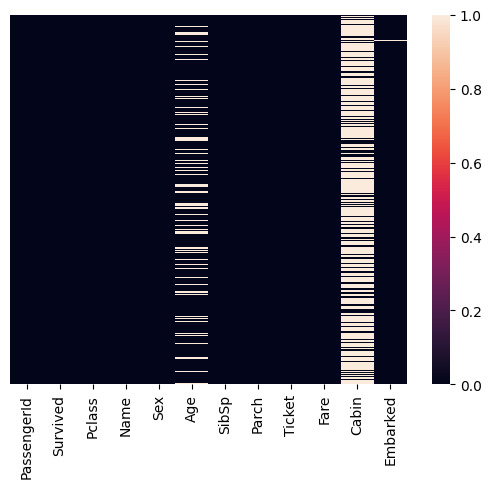

In [2]:
sns.heatmap(titanic_data_train.isnull(), yticklabels=False)
titanic_data_train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

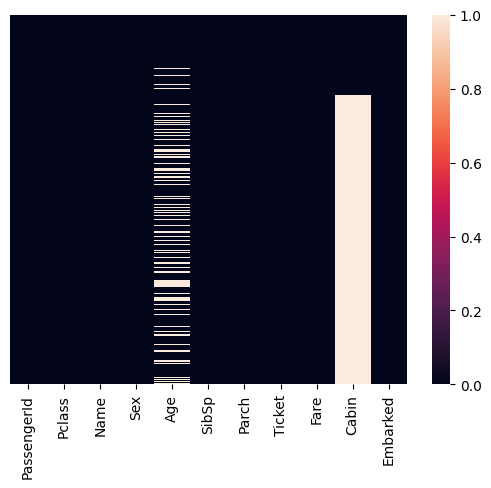

In [3]:
sns.heatmap(titanic_data_test.isnull(), yticklabels=False)
titanic_data_test.isnull().sum()

<Axes: >

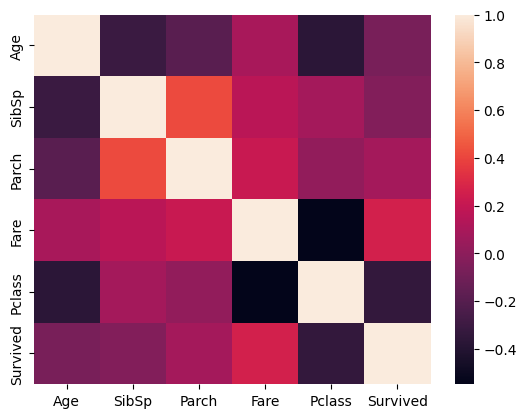

In [4]:
#seperate the data into numeric and categorical
df_num = titanic_data_train[['Age','SibSp','Parch','Fare','Pclass','Survived']]
df_cat = titanic_data_train[['Survived','Sex','Ticket','Cabin','Embarked']]

#titanic_data_train.drop(['PassengerId'], axis=1, inplace=True)
#Drop passengerId  as it dosn't correlate to survival, won't drop it from test as it required
#will not drop passengerId from test as it is  required for submission

sns.heatmap(df_num.corr())
#High Correlation between Parch ans SibSp
#Parents generally travel with their 1 or more kids
#Children travel with their single or both parents and/or siblings

In [5]:
pd.pivot_table(titanic_data_train, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])
#The average age of survivors is 28, so young people tend to survive more.
#People who paid higher fare rates were more likely to survive, more than double fare. This might be the people traveling in first-class.
#In the 3rd column, If you have parents, you had a higher chance of surviving. So the parents might’ve saved the kids before themselves, thus explaining the rates
#And if you are a child, and have siblings, you have less of a chance of surviving

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


In [6]:
pd.pivot_table(titanic_data_train, index = 'Survived', columns='Pclass', values='Ticket', aggfunc='count')

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [7]:
pd.pivot_table(titanic_data_train, index = 'Survived', columns='Sex', values='Ticket', aggfunc='count')

Sex,female,male
Survived,,
0,81,468
1,233,109


In [8]:
pd.pivot_table(titanic_data_train, index = 'Survived', columns='Embarked', values='Ticket', aggfunc='count')
# 33% people who embarked at Southampton survived
# 55% people who embarked at Cherbough survived
# 38% people who embarked at Queenstown survived

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


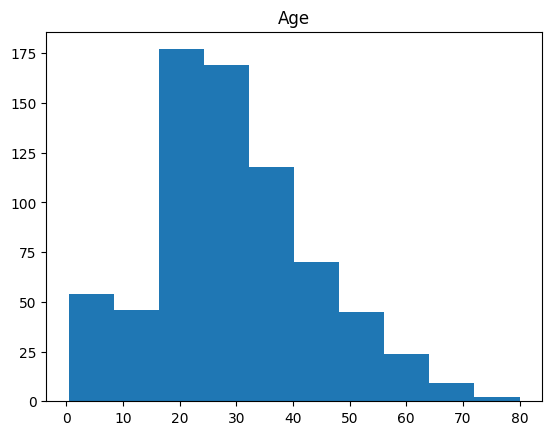

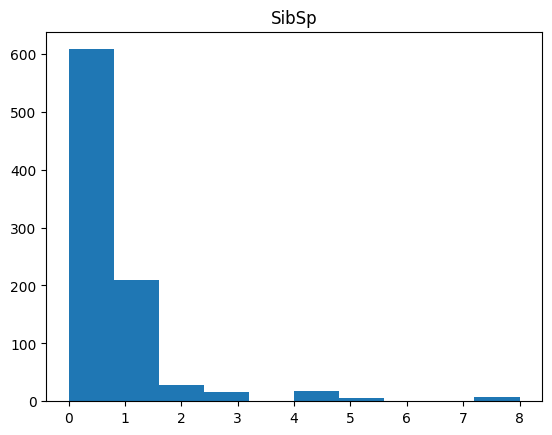

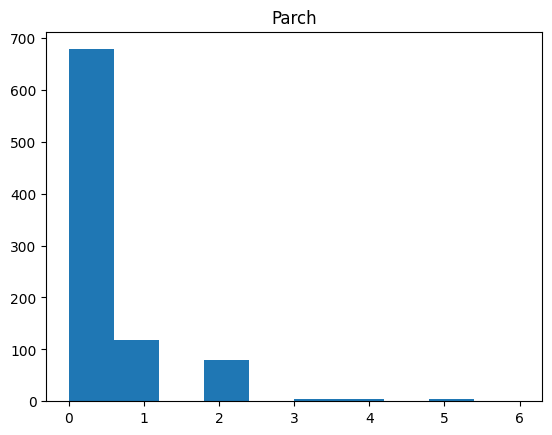

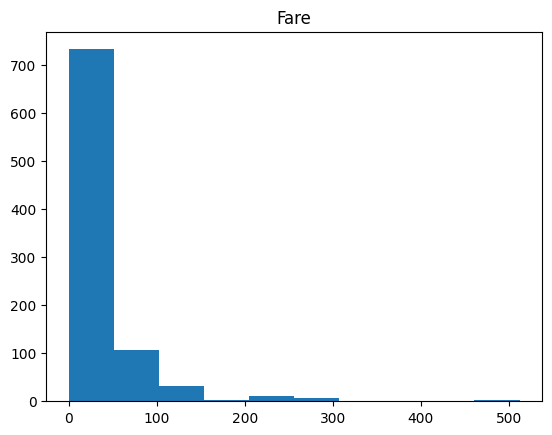

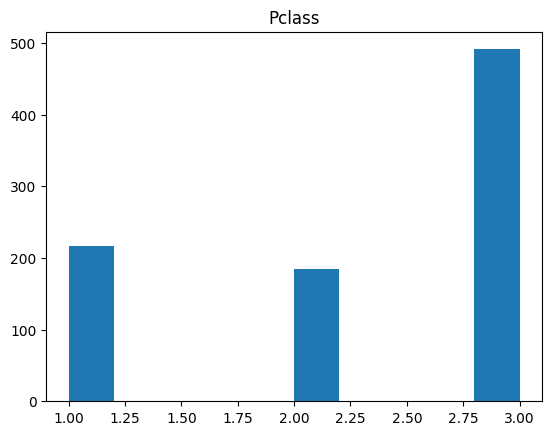

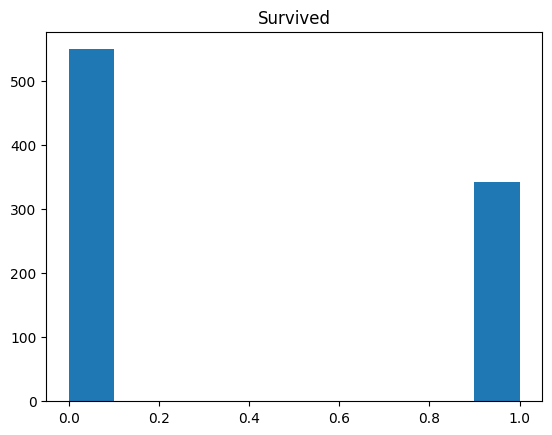

In [9]:
#all numerical columns plotted as histogram
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

In [10]:
total_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
import re
# n stands for null


##Only 1 passenger in T Deck, being 1st class, let's put him in A.
##A,B, C were only 1st class
##D and E have same passenger dist and same survival rate

total_data['Cabin'] = total_data['Cabin'].fillna("M")
total_data['Deck'] = total_data['Cabin'].map(lambda x: str(x)[0])
idx = total_data[total_data['Deck'] == 'T'].index
total_data.loc[idx, 'Deck'] = 'A'


deck_dict ={"ABC":1, "DE":2, "FG":3, "M":4}
## Grouping done after checking the %age distribution of passengers classwise and survival rate
total_data['Deck'] = total_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
total_data['Deck'] = total_data['Deck'].replace(['D', 'E'], 'DE')
total_data['Deck'] = total_data['Deck'].replace(['F', 'G'], 'FG')

total_data['Deck'].value_counts()
total_data['Deck'] = total_data['Deck'].map(deck_dict) 
total_data['Deck'] = total_data['Deck'].fillna(0)
total_data['Deck'] = total_data['Deck'].astype(int)


In [12]:
total_data.drop(['Cabin'], axis=1, inplace=True)
total_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,4
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,4
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,4


In [13]:
## STRIP THE TITLE

In [14]:
#titles_dict ={"Mr":1, "Miss":2, "Mrs":3,"Master":4, "Rare":5 }

total_data['title'] = total_data.Name.apply(lambda x: x.split(',')[1]
                                                        .split('.')[0].strip())
total_data['title'] = total_data['title'].replace(['Dr','Rev','Major','Col',\
                                                           'Capt','Sir',\
                                                           'Don','Jonkheer'],'Rare') 
total_data['title'] = total_data['title'].replace(['Mlle','Dona'],'Miss')
total_data['title'] = total_data['title'].replace(['Ms','Mme','Lady','the Countess'],'Mrs')
total_data['title'] = total_data['title'].replace(['Miss','Mrs'],'Miss|Mrs')
#total_data['title'] = total_data['title'].map(titles_dict)
total_data['title'] = total_data['title'].fillna(0)
#total_data['title'] = total_data['title'].astype(int)

total_data['Is_Married'] = 0
total_data['Is_Married'].loc[total_data['title'] == 'Mrs'] = 1

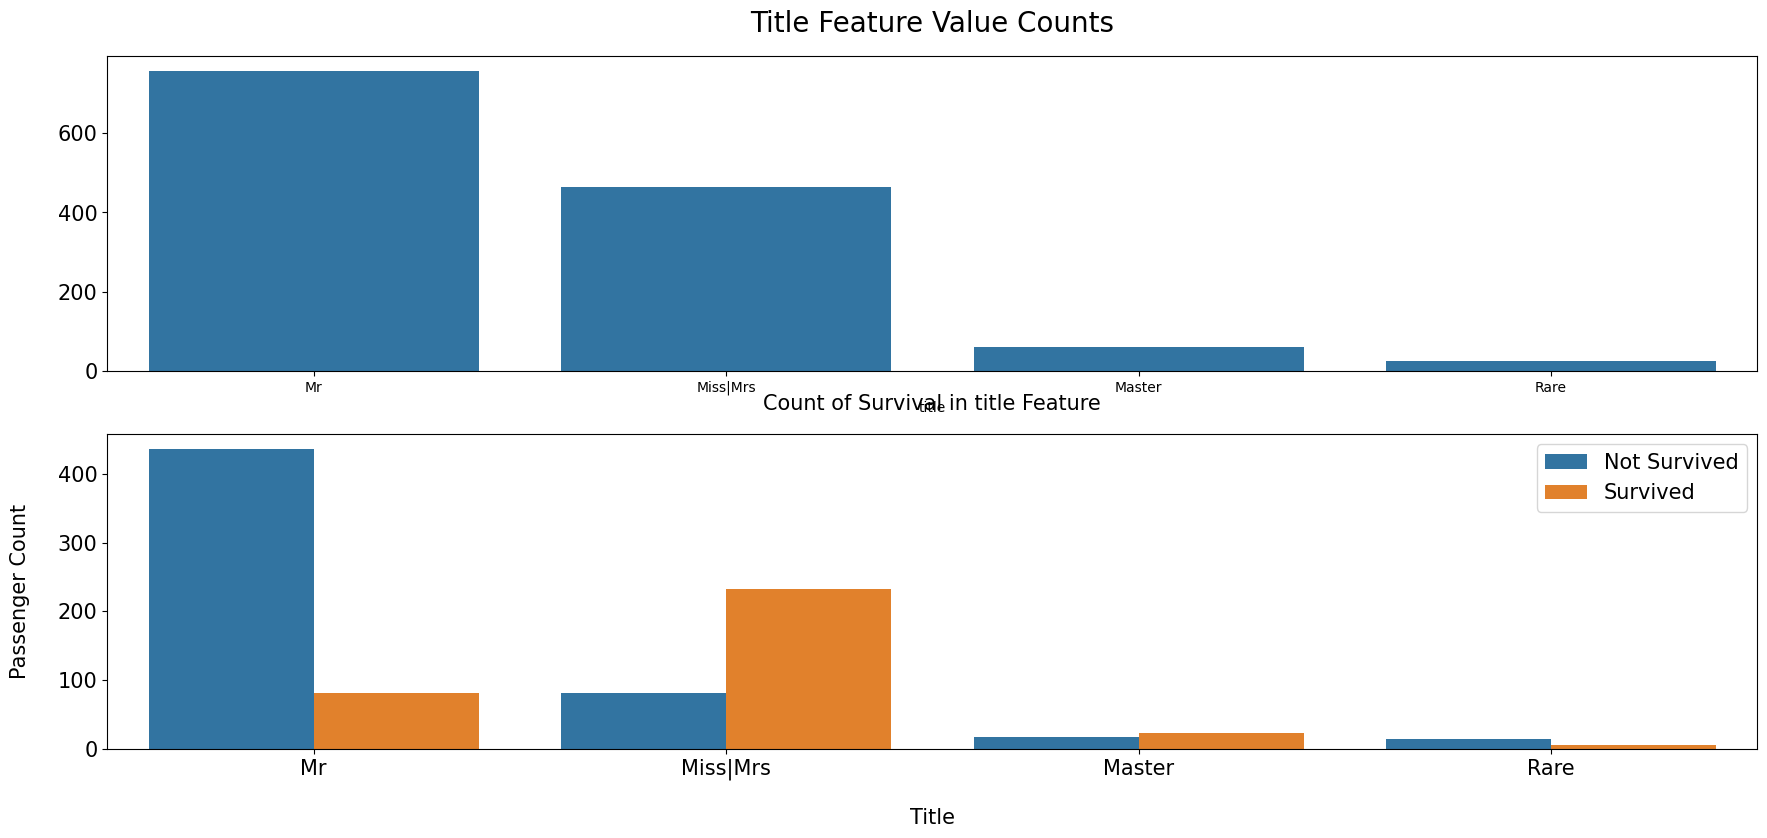

In [15]:
fig, axs = plt.subplots(nrows=2, figsize=(12, 9))
plt.subplots_adjust(right=1.5)

sns.barplot(x=total_data['title'].value_counts().index, y=total_data['title'].value_counts().values, ax=axs[0])
axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=15)
axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)


sns.countplot(x='title', hue='Survived', data=total_data, ax=axs[1])


plt.xlabel('Title', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('title'), size=15, y=1.05)

plt.show()

In [16]:
total_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,title,Is_Married
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,4,Mr,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,Miss|Mrs,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,4,Miss|Mrs,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,Miss|Mrs,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,4,Mr,0


# Normalization of Age

In [17]:
##Embarked is a categorical feature and there are only 2 missing values in whole data set. 
total_data[total_data['Embarked'].isnull()]
#Both of those passengers are female, upper class and they have the same ticket number.
#This means that they know each other and embarked from the same port together. 
#The mode Embarked value for an upper class female passenger is C (Cherbourg), but this doesn't necessarily mean that they embarked from that port.
#Checked online and found both of them embarked in SouthApmton and worked booked in the ame cabin, Icard wasMrs. Stone's maid
print(total_data['Embarked'].mode())
total_data['Embarked'] = total_data['Embarked'].fillna('S')
#total_data.replace({'Sex':{'male':0,'female':1}, 'Embarked':{'S':0,'C':1,'Q':2}}, inplace=True)
#total_data.head(5)


0    S
Name: Embarked, dtype: object


In [18]:
## Age and PClass have very high -ve correlation 0.4
## But females have a higher chance of survival than males in any class.

age_by_pclass_sex = total_data.groupby(['Pclass','Sex'])['Age'].median()


for pclass in range(1,4):
    for sex in [0,1]:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[pclass][sex]))

print('Median age of all passengers: {}'.format(total_data['Age'].median()))
          
#total_data['Age'] = total_data.groupby(['Pclass','Sex'])['Age'].apply(lambda x: x.fillna(x.median()))    
nan_values = total_data[total_data['Age'].isna()]
#print (nan_values)

age_slice = total_data['Age'].copy()
for ind in total_data.index:
    if (pd.isnull(total_data['Age'][ind])):
        m_pclass = total_data['Pclass'][ind]
        m_sex = total_data['Sex'][ind]
        x_age = age_by_pclass_sex[m_pclass][m_sex]
        age_slice[ind]= x_age

total_data['Age'] = age_slice
total_data['Age'] = total_data['Age'].astype(int)
#total_data['Age'].head(20)
total_data['Age'].isnull().sum()

Median age of Pclass 1 0s: 36.0
Median age of Pclass 1 1s: 42.0
Median age of Pclass 2 0s: 28.0
Median age of Pclass 2 1s: 29.5
Median age of Pclass 3 0s: 22.0
Median age of Pclass 3 1s: 25.0
Median age of all passengers: 28.0


0

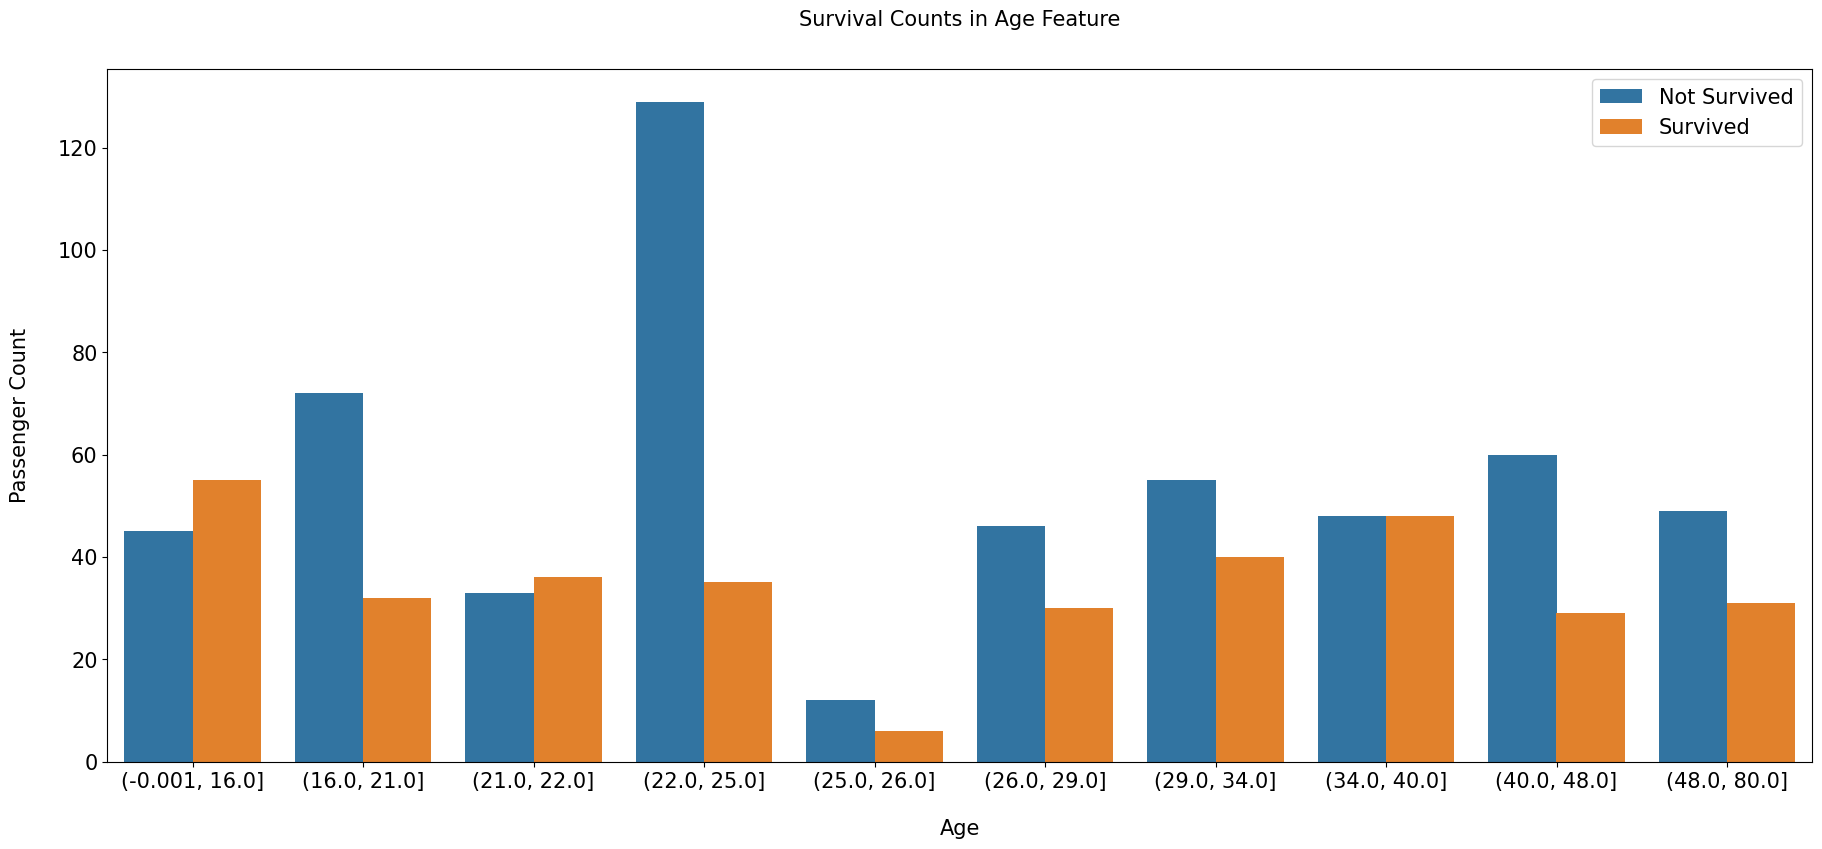

In [19]:
#titanic_data_train['Age'].describe()
#pd.pivot_table(titanic_data_train, index = 'Survived', columns = 'Age',
 #              values = 'Ticket' ,aggfunc ='count')

total_data['Age'] = pd.qcut(total_data['Age'], 10, duplicates='drop')
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=total_data)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

##Normalization of Fare

In [20]:
total_data['Fare'].isnull().sum()
fare_by_pclass_parch_sibsp = total_data.groupby(['Pclass','Parch','SibSp'])['Fare'].median()

#total_data['Fare'] = total_data.groupby(['Pclass','Parch','SibSp'])['Fare'].apply(lambda x: x.fillna(x.median()))
fare_slice = total_data['Fare'].copy()
for ind in total_data.index:
    if (pd.isnull(total_data['Fare'][ind])):
        m_pclass = total_data['Pclass'][ind]
        m_parch = total_data['Parch'][ind]
        m_sibsp = total_data['SibSp'][ind]
        x_fare = fare_by_pclass_parch_sibsp[m_pclass][m_parch][m_sibsp]
        fare_slice[ind]= x_fare

total_data['Fare'] = fare_slice
total_data['Fare'] = total_data['Fare'].astype(int)      

total_data.head(5)
#total_data['Fare'].describe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,title,Is_Married
0,1,0.0,3,"Braund, Mr. Owen Harris",male,"(21.0, 22.0]",1,0,A/5 21171,7,S,4,Mr,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,"(34.0, 40.0]",1,0,PC 17599,71,C,1,Miss|Mrs,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,"(25.0, 26.0]",0,0,STON/O2. 3101282,7,S,4,Miss|Mrs,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,"(34.0, 40.0]",1,0,113803,53,S,1,Miss|Mrs,0
4,5,0.0,3,"Allen, Mr. William Henry",male,"(34.0, 40.0]",0,0,373450,8,S,4,Mr,0


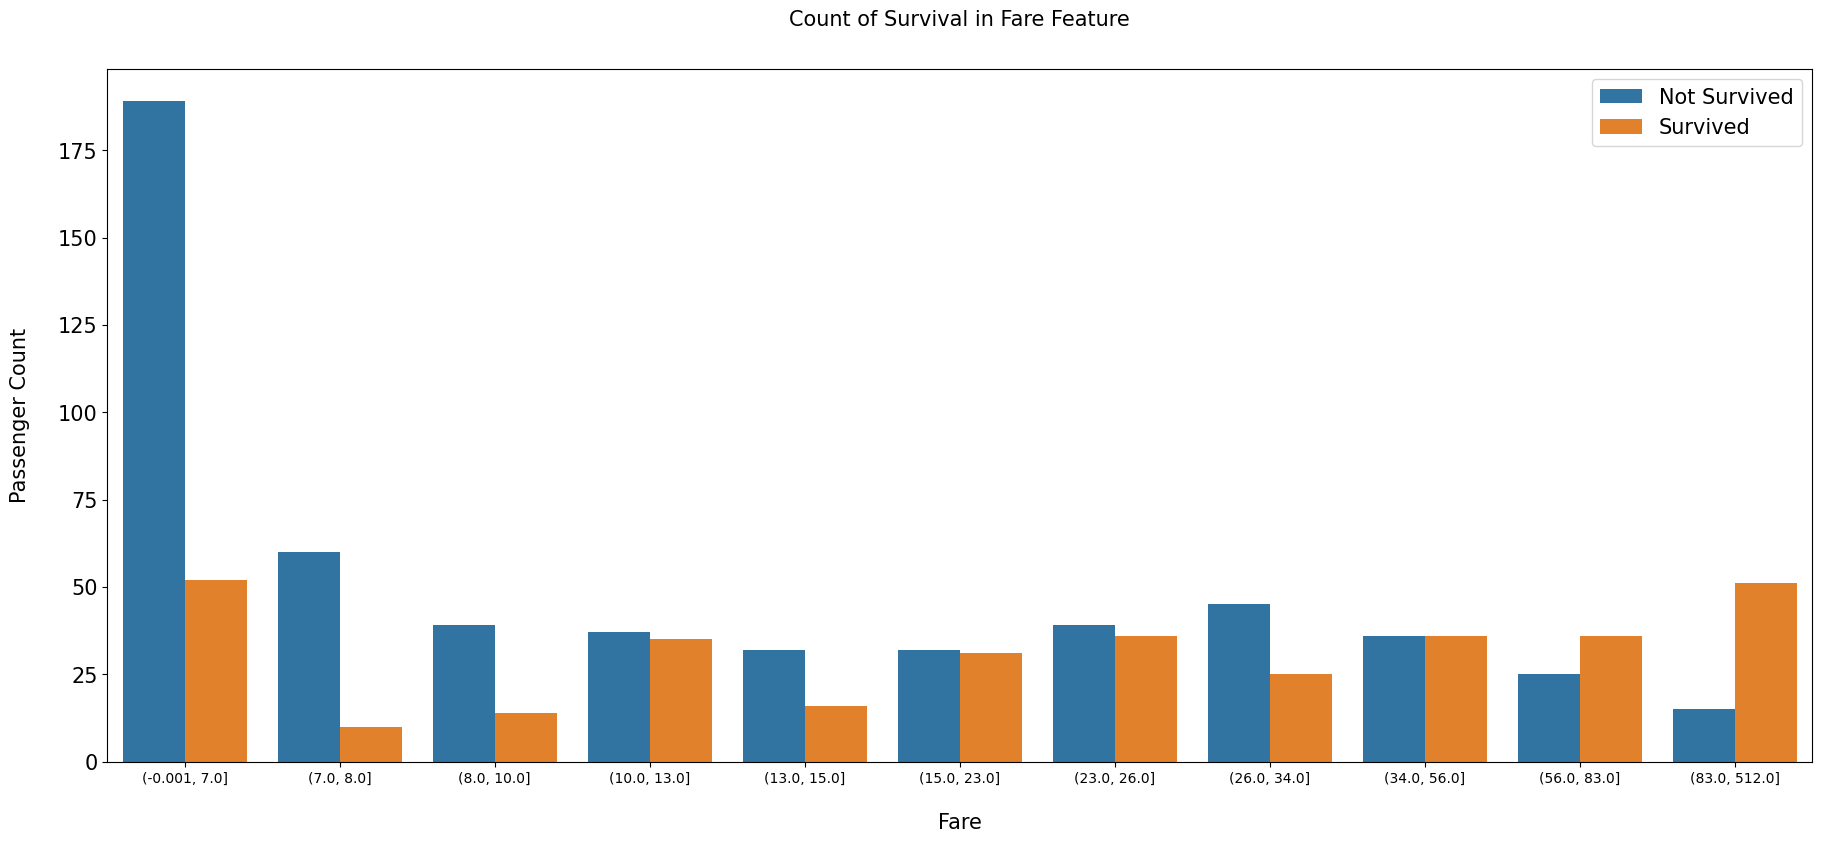

In [21]:
total_data['Fare'] = pd.qcut(total_data['Fare'], 13, duplicates='drop')
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=total_data)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

Text(0.5, 1.05, 'Survival Counts in Family Size After Grouping')

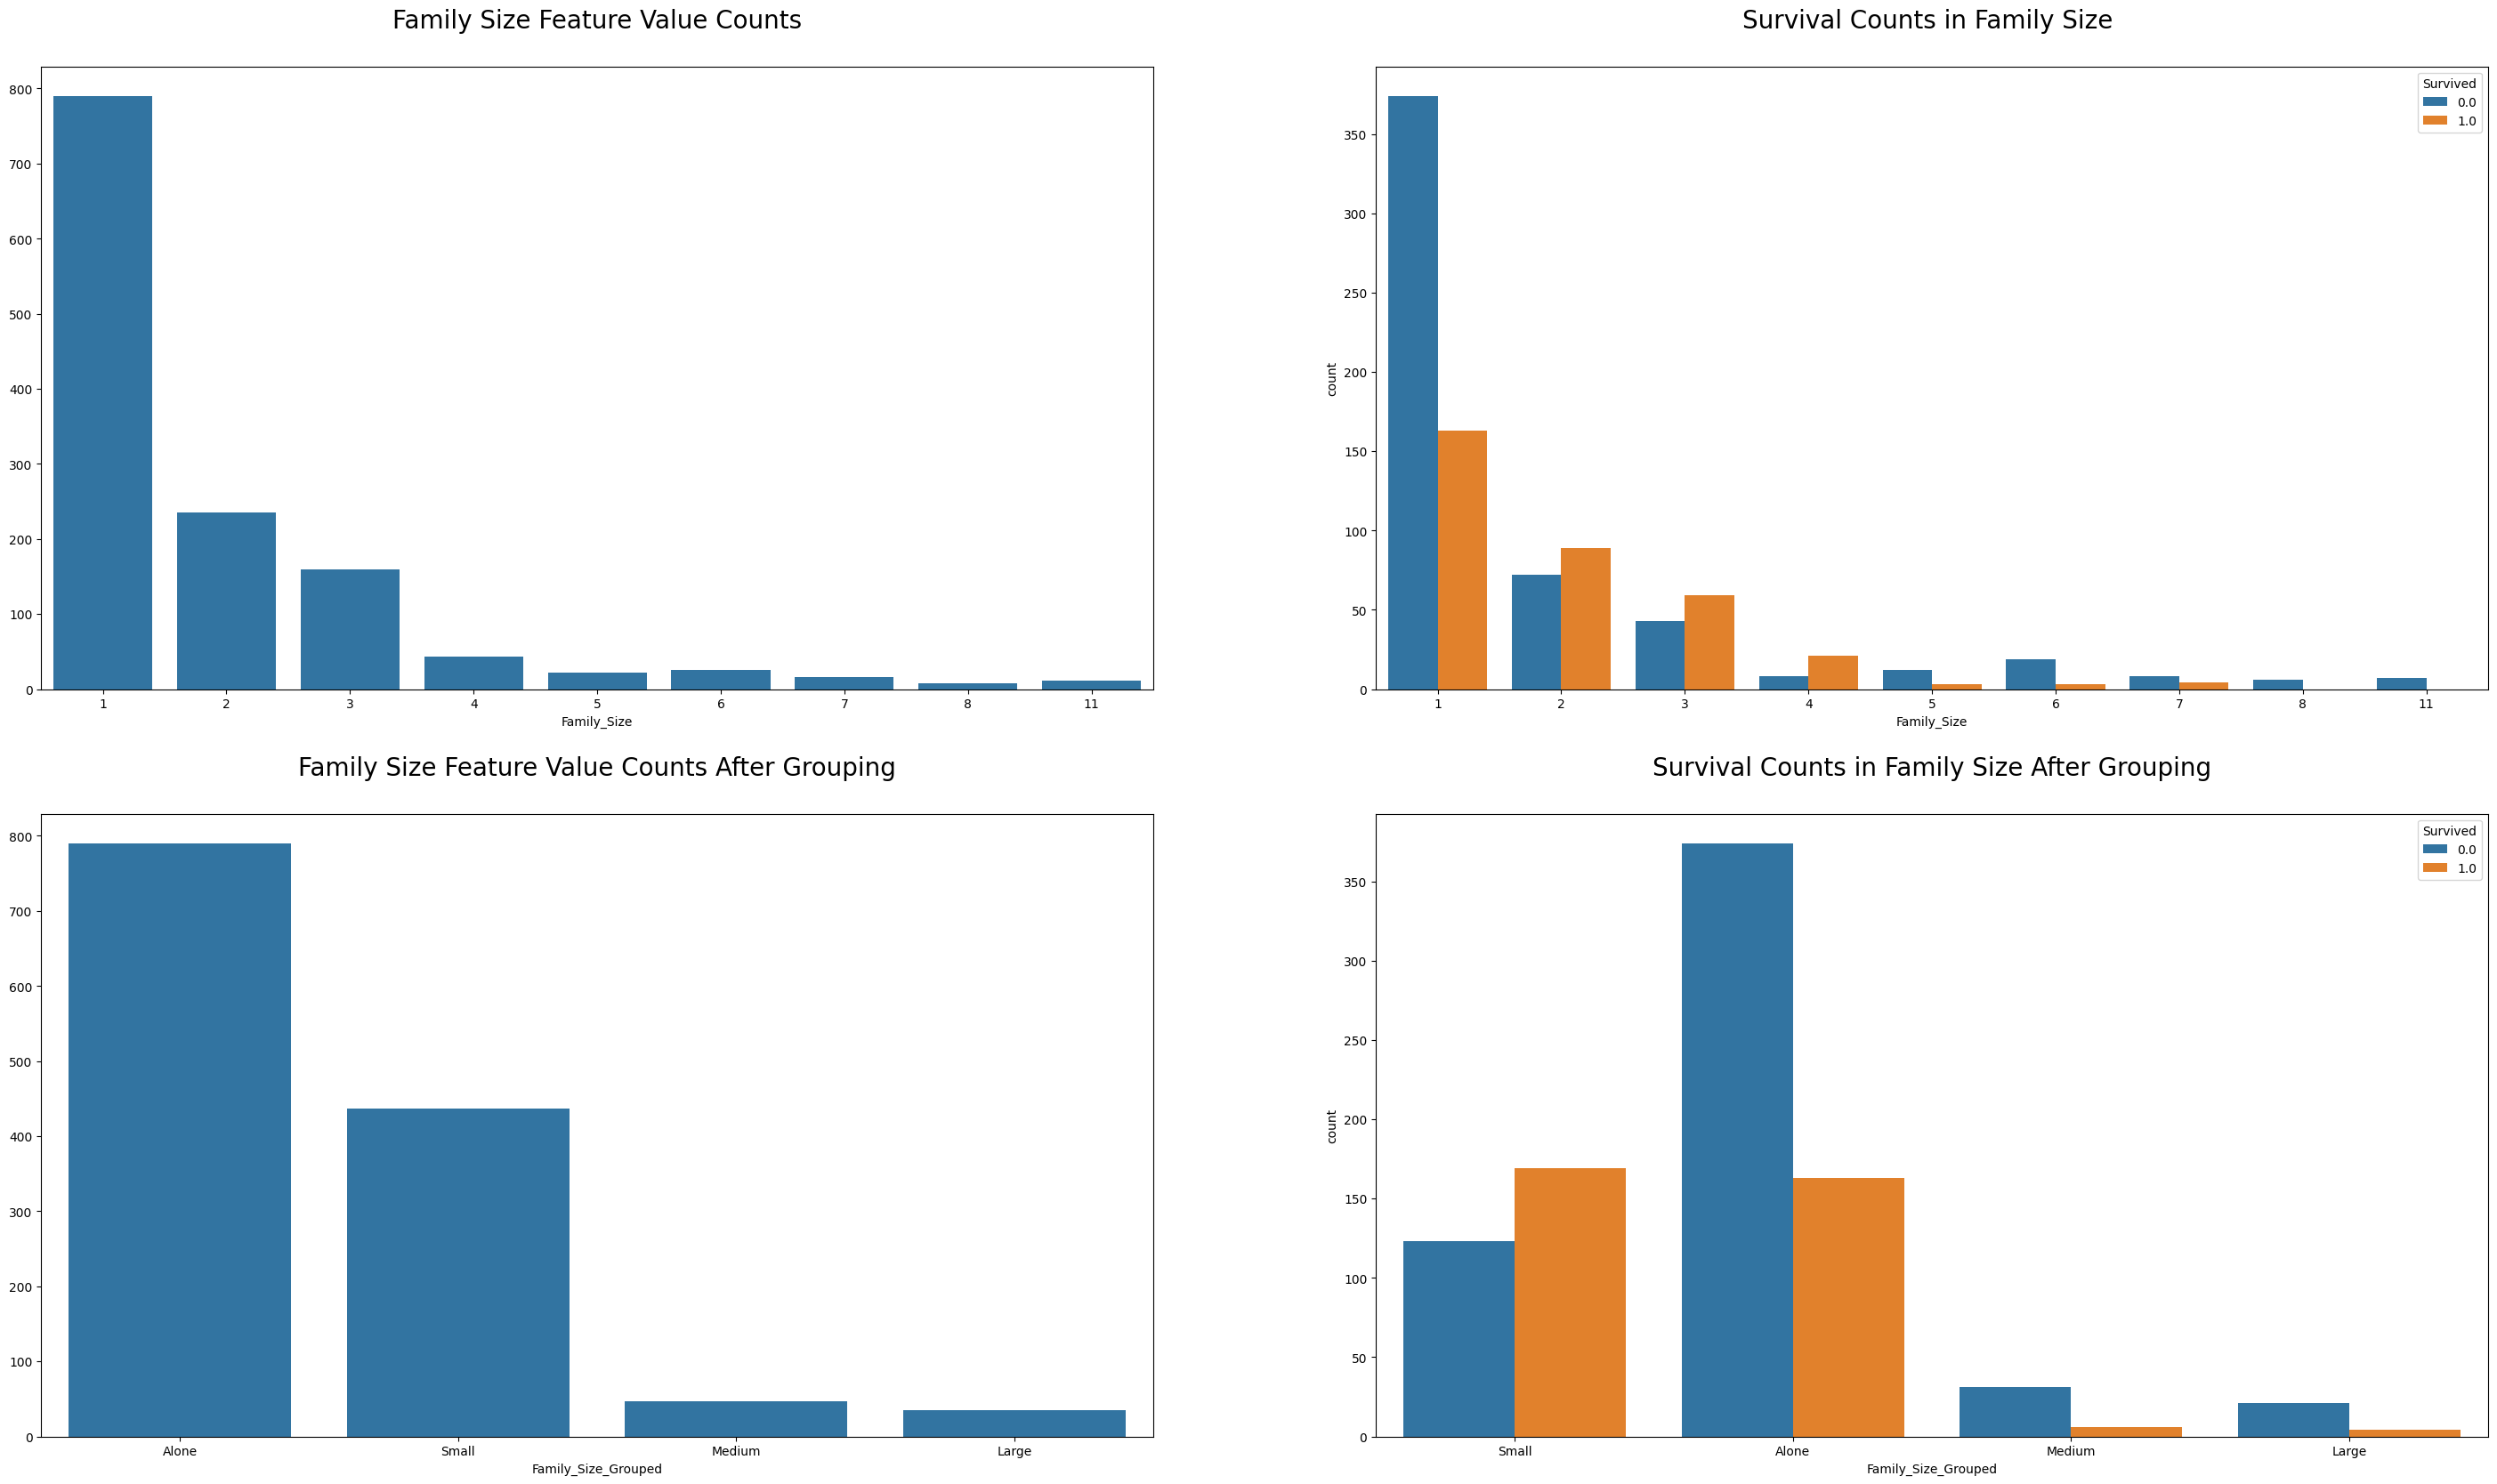

In [22]:
total_data['Family_Size'] = total_data['SibSp'] + total_data['Parch'] + 1
total_data['Family_Size'] = total_data['Family_Size'].astype(int)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=total_data['Family_Size'].value_counts().index, y=total_data['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=total_data, ax=axs[0][1])
axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

total_data['Family_Size_Grouped'] = total_data['Family_Size'].map(family_map)


sns.barplot(x=total_data['Family_Size_Grouped'].value_counts().index, y=total_data['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=total_data, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)




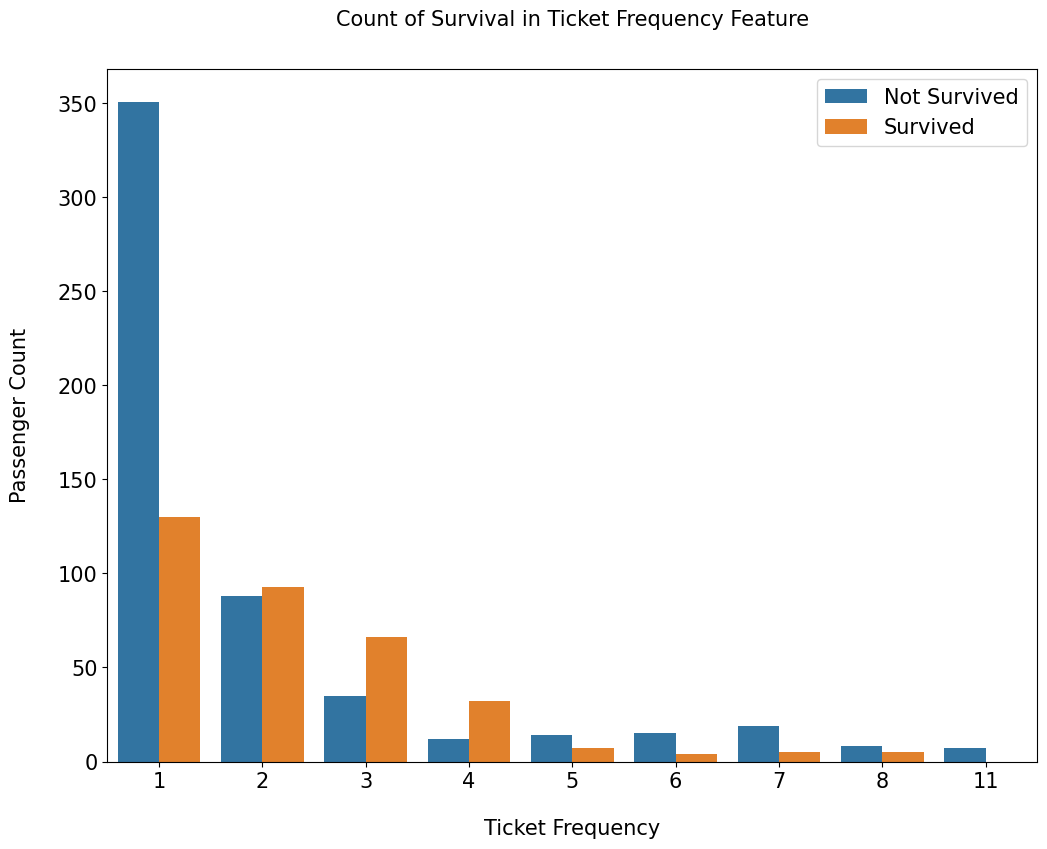

In [23]:
total_data['Ticket_Frequency'] = total_data.groupby('Ticket')['Ticket'].transform('count')

fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=total_data)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

In [24]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

total_data['Family'] = extract_surname(total_data['Name'])
titanic_data_train = total_data.loc[:890]
titanic_data_test = total_data.loc[891:]
dfs = [titanic_data_train, titanic_data_test]

In [25]:
titanic_data_train.groupby('Family').first()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,title,Is_Married,Family_Size,Family_Size_Grouped,Ticket_Frequency
Family,,,,,,,,,,,,,,,,,
Abbing,846,0.0,3,"Abbing, Mr. Anthony",male,"(40.0, 48.0]",0,0,C.A. 5547,"(-0.001, 7.0]",S,4,Mr,0,1,Alone,1
Abbott,280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,"(34.0, 40.0]",1,1,C.A. 2673,"(15.0, 23.0]",S,4,Miss|Mrs,0,3,Small,3
Abelson,309,0.0,2,"Abelson, Mr. Samuel",male,"(29.0, 34.0]",1,0,P/PP 3381,"(23.0, 26.0]",C,4,Mr,0,2,Small,2
Adahl,366,0.0,3,"Adahl, Mr. Mauritz Nils Martin",male,"(29.0, 34.0]",0,0,C 7076,"(-0.001, 7.0]",S,4,Mr,0,1,Alone,1
Adams,402,0.0,3,"Adams, Mr. John",male,"(25.0, 26.0]",0,0,341826,"(7.0, 8.0]",S,4,Mr,0,1,Alone,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
de Mulder,287,1.0,3,"de Mulder, Mr. Theodore",male,"(29.0, 34.0]",0,0,345774,"(8.0, 10.0]",S,4,Mr,0,1,Alone,1
de Pelsmaeker,283,0.0,3,"de Pelsmaeker, Mr. Alfons",male,"(-0.001, 16.0]",0,0,345778,"(8.0, 10.0]",S,4,Mr,0,1,Alone,1
del Carlo,362,0.0,2,"del Carlo, Mr. Sebastiano",male,"(26.0, 29.0]",1,0,SC/PARIS 2167,"(26.0, 34.0]",C,4,Mr,0,2,Small,2


In [26]:
non_unique_families = [x for x in titanic_data_train['Family'].unique() if x in titanic_data_test['Family'].unique()]
non_unique_tickets = [x for x in titanic_data_train['Ticket'].unique() if x in titanic_data_test['Ticket'].unique()]

df_family_survival_rate = titanic_data_train.groupby(['Family'])[['Survived','Family_Size']].median()
df_ticket_survival_rate = titanic_data_train.groupby(['Ticket'])[['Survived','Ticket_Frequency']].median()


family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]
        #print('Family survival rate ' + str(family_rates[df_family_survival_rate.index[i]]))
        

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]
        

In [27]:
mean_survival_rate = np.mean(titanic_data_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(titanic_data_train)):
    if titanic_data_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[titanic_data_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(titanic_data_test)):
    if titanic_data_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[titanic_data_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)

titanic_data_train['Family_Survival_Rate'] = train_family_survival_rate
titanic_data_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
titanic_data_test['Family_Survival_Rate'] = test_family_survival_rate
titanic_data_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA


train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(titanic_data_train)):
    if titanic_data_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[titanic_data_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(titanic_data_test)):
    if titanic_data_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[titanic_data_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
titanic_data_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
titanic_data_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
titanic_data_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
titanic_data_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

titanic_data_train.tail(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,title,Is_Married,Family_Size,Family_Size_Grouped,Ticket_Frequency,Family,Family_Survival_Rate,Family_Survival_Rate_NA,Ticket_Survival_Rate,Ticket_Survival_Rate_NA
886,887,0.0,2,"Montvila, Rev. Juozas",male,"(26.0, 29.0]",0,0,211536,"(10.0, 13.0]",...,Rare,0,1,Alone,1,Montvila,0.383838,0,0.383838,0
887,888,1.0,1,"Graham, Miss. Margaret Edith",female,"(16.0, 21.0]",0,0,112053,"(26.0, 34.0]",...,Miss|Mrs,0,1,Alone,1,Graham,0.383838,0,0.383838,0
888,889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,"(21.0, 22.0]",1,2,W./C. 6607,"(15.0, 23.0]",...,Miss|Mrs,0,4,Small,4,Johnston,0.000000,1,0.000000,1
889,890,1.0,1,"Behr, Mr. Karl Howell",male,"(25.0, 26.0]",0,0,111369,"(26.0, 34.0]",...,Mr,0,1,Alone,1,Behr,0.383838,0,0.383838,0
890,891,0.0,3,"Dooley, Mr. Patrick",male,"(29.0, 34.0]",0,0,370376,"(-0.001, 7.0]",...,Mr,0,1,Alone,1,Dooley,0.383838,0,0.383838,0


In [28]:
for df in [titanic_data_train, titanic_data_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2    

In [29]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [30]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

titanic_data_train = pd.concat([titanic_data_train, *encoded_features[:6]], axis=1)
titanic_data_test = pd.concat([titanic_data_test, *encoded_features[6:]], axis=1)

In [31]:
df_all = pd.concat([titanic_data_train,titanic_data_test], ignore_index=True)
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)
df_all.head()

,Age,Fare,Is_Married,Family_Size_Grouped,Ticket_Frequency,Survival_Rate,Survival_Rate_NA,Pclass_1,Pclass_2,Pclass_3,...,Embarked_2,Embarked_3,title_1,title_2,title_3,title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
0,2,0,0,3,1,0.383838,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,7,9,0,3,2,1.000000,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,4,0,0,0,1,0.383838,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,7,8,0,3,2,0.383838,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7,1,0,0,1,0.383838,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


##  Train and Test Data

In [32]:
titanic_data_train.isnull().sum()

PassengerId                0
Survived                   0
Pclass                     0
Name                       0
Sex                        0
Age                        0
SibSp                      0
Parch                      0
Ticket                     0
Fare                       0
Embarked                   0
Deck                       0
title                      0
Is_Married                 0
Family_Size                0
Family_Size_Grouped        0
Ticket_Frequency           0
Family                     0
Family_Survival_Rate       0
Family_Survival_Rate_NA    0
Ticket_Survival_Rate       0
Ticket_Survival_Rate_NA    0
Survival_Rate              0
Survival_Rate_NA           0
Pclass_1                   0
Pclass_2                   0
Pclass_3                   0
Sex_1                      0
Sex_2                      0
Deck_1                     0
Deck_2                     0
Deck_3                     0
Deck_4                     0
Embarked_1                 0
Embarked_2    

In [33]:
titanic_data_test.isnull().sum()

PassengerId                  0
Survived                   418
Pclass                       0
Name                         0
Sex                          0
Age                          0
SibSp                        0
Parch                        0
Ticket                       0
Fare                         0
Embarked                     0
Deck                         0
title                        0
Is_Married                   0
Family_Size                  0
Family_Size_Grouped          0
Ticket_Frequency             0
Family                       0
Family_Survival_Rate         0
Family_Survival_Rate_NA      0
Ticket_Survival_Rate         0
Ticket_Survival_Rate_NA      0
Survival_Rate                0
Survival_Rate_NA             0
Pclass_1                     0
Pclass_2                     0
Pclass_3                     0
Sex_1                        0
Sex_2                        0
Deck_1                       0
Deck_2                       0
Deck_3                       0
Deck_4  

In [34]:
titanic_data_train.columns = titanic_data_train.columns.astype(str)
titanic_data_test.columns = titanic_data_test.columns.astype(str)

X_train = StandardScaler().fit_transform(titanic_data_train.drop(columns=drop_cols))
y_train = titanic_data_train['Survived'].values
X_test = StandardScaler().fit_transform(titanic_data_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))



X_train shape: (891, 27)
y_train shape: (891,)
X_test shape: (418, 27)


In [35]:
single_best_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1) 

In [36]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    leaderboard_model.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], leaderboard_model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], leaderboard_model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_
        
    oob += leaderboard_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_model.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 1 OOB Score: 0.8567415730337079

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 2 OOB Score: 0.844319775596073

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 3 OOB Score: 0.85273492286115

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 4 OOB Score: 0.8359046283309958

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 5 OOB Score: 0.8246844319775596

Average OOB Score: 0.8428770663598972


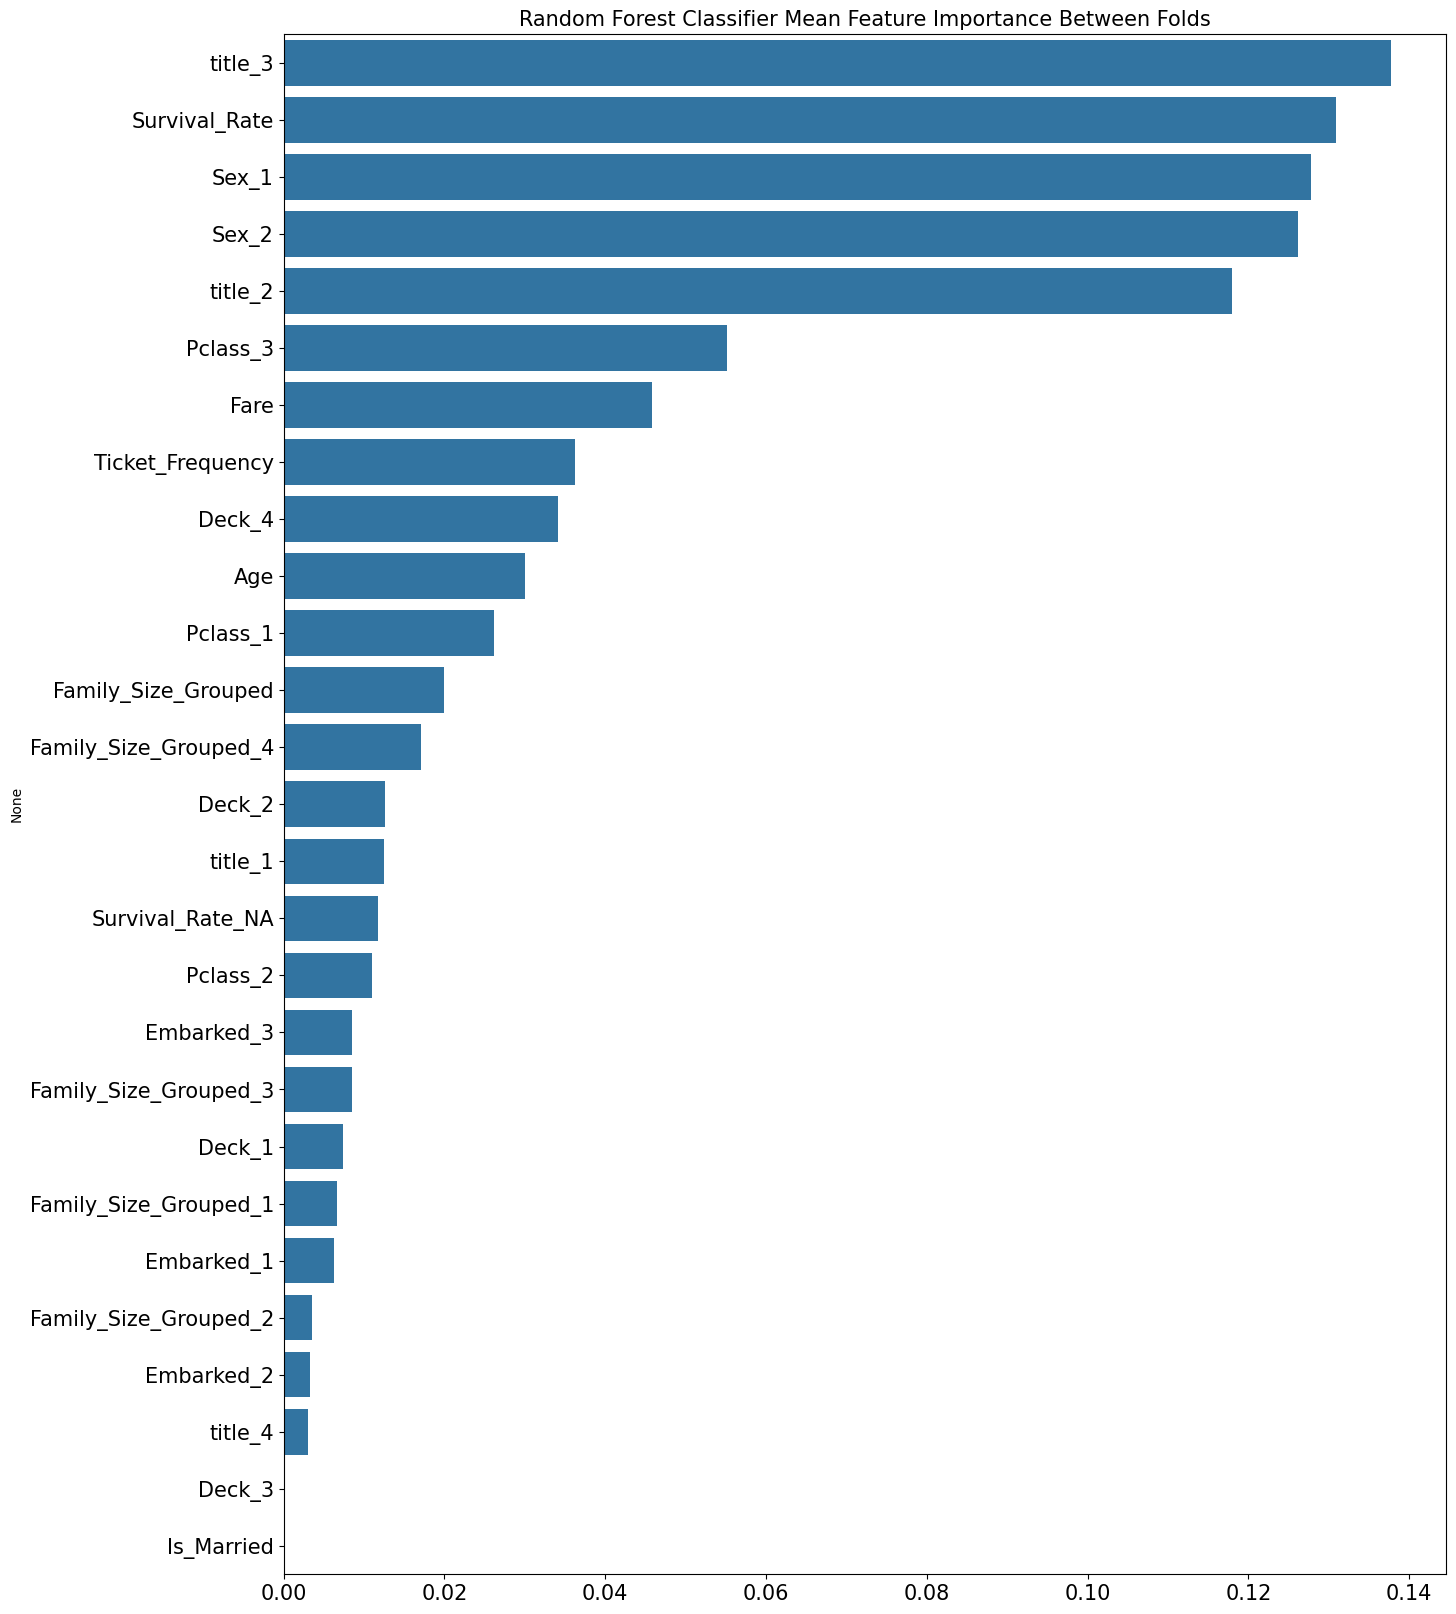

In [37]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

In [38]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = titanic_data_test['PassengerId']
submission_df['Survived'] = y_pred.values
pred_csv = submission_df.to_csv('Titanic_Survival_Prediction', header =True, index = True)
submission_df.head(10)

,PassengerId,Survived
891,1100,1
892,1223,0
893,920,0
894,1004,1
895,1185,1
896,1266,1
897,938,0
898,1058,0
899,1107,0
900,1282,0
